In [1]:
#import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#load data
file = 'chirps_full_WA.nc'
data = xr.open_dataset(file)
data = xr.open_dataset('chirps_full_WA.nc')
data = data['precip'].where(data['precip']!=-99)

In [3]:
# data

In [4]:
#extracting data for part of the Sudano-Sahelian zone
Sudano= data.sel(latitude=slice(8,12),longitude=slice(-18,18))
Sudano

<xarray.DataArray 'precip' (time: 10958, latitude: 16, longitude: 80)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.00997079, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.01435433, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00309874, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2020-12-31
  * latitude   (latitude) float32 8.125 8.375 8.625 8.875 ... 11.38 11.62 11.88
  * longitude  (longitude) float32 -9.875 -9.625 -9.375 ... 9.375 9.625 9.875
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [5]:
doy_data = Sudano.mean(['longitude','latitude']).groupby('time.dayofyear')
doy_data

DataArrayGroupBy, grouped over 'dayofyear'
366 groups with labels 1, 2, 3, 4, 5, ..., 363, 364, 365, 366.

In [6]:
doy_data[6]

<xarray.DataArray 'precip' (time: 30)>
array([2.2756655e-02, 8.2199590e-04, 1.1924962e-02, 1.9575811e-05,
       1.1266537e-02, 5.0262203e-03, 2.1078803e-03, 1.9865854e-02,
       8.2851402e-05, 2.5470918e-02, 1.3088545e-01, 1.5759197e-01,
       0.0000000e+00, 0.0000000e+00, 2.4976113e-03, 1.9920684e-02,
       6.6603876e-05, 3.9449550e-02, 5.4506259e-03, 0.0000000e+00,
       4.0610111e-04, 2.0556739e-05, 1.3434038e-02, 7.4929059e-03,
       0.0000000e+00, 3.7172610e-01, 2.0522368e-03, 0.0000000e+00,
       1.8339474e-01, 1.1970237e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-06 1992-01-06 ... 2020-01-06

In [7]:
#Function for Anomaly Computation & Data Check for inf values
def ano(x,dim):
    return (x-x.mean(dim=dim))

def inf_check(p, grid=True):
    if grid==True:
        p = p.where(p!=np.inf).where(p!=-np.inf)
    else:
        p[np.isinf(p)==True] = np.nan
    return p

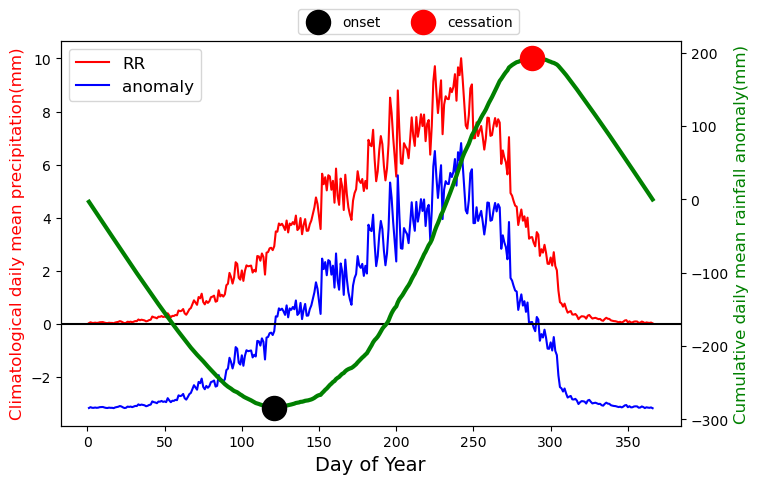

In [13]:
x = list(doy_data.groups.copy())
fig, ax = plt.subplots(figsize=(8,5))

avg_data = inf_check(doy_data.mean(),grid=True)
avg_data.plot(ax = ax,color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
ax.legend(loc='upper left', fontsize=12)
ax.set_ylabel('Climatological daily mean precipitation(mm)', color='r', fontsize=12 )
# # ax.set_ylabel('Climatological daily mean precipitation anomaly(mm/day)', color='b', ha ='left', fontsize=12)

ax.set_xlabel('Day of Year', fontsize=14)


ax.axhline(y=0, color='k')   #horizontal black line at the zero mark


ax1 = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
ax1.plot(x, anom, color='g', linewidth=3)
ax1.set_ylabel('Cumulative daily mean rainfall anomaly(mm)', fontsize=12, color='g')     #set labe
            

#Onset and Cessation Detection                 
anomaly = anom.values
dx = 28 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    
            
ax1.scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
ax1.scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
ax1.legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))      
fig.savefig('Sudano-sahel_zone')
                

In [9]:
yearly_data = Sudano.mean(['longitude','latitude']).groupby('time.year')
yearly_data 

DataArrayGroupBy, grouped over 'year'
30 groups with labels 1991, 1992, 1993, ..., 2019, 2020.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

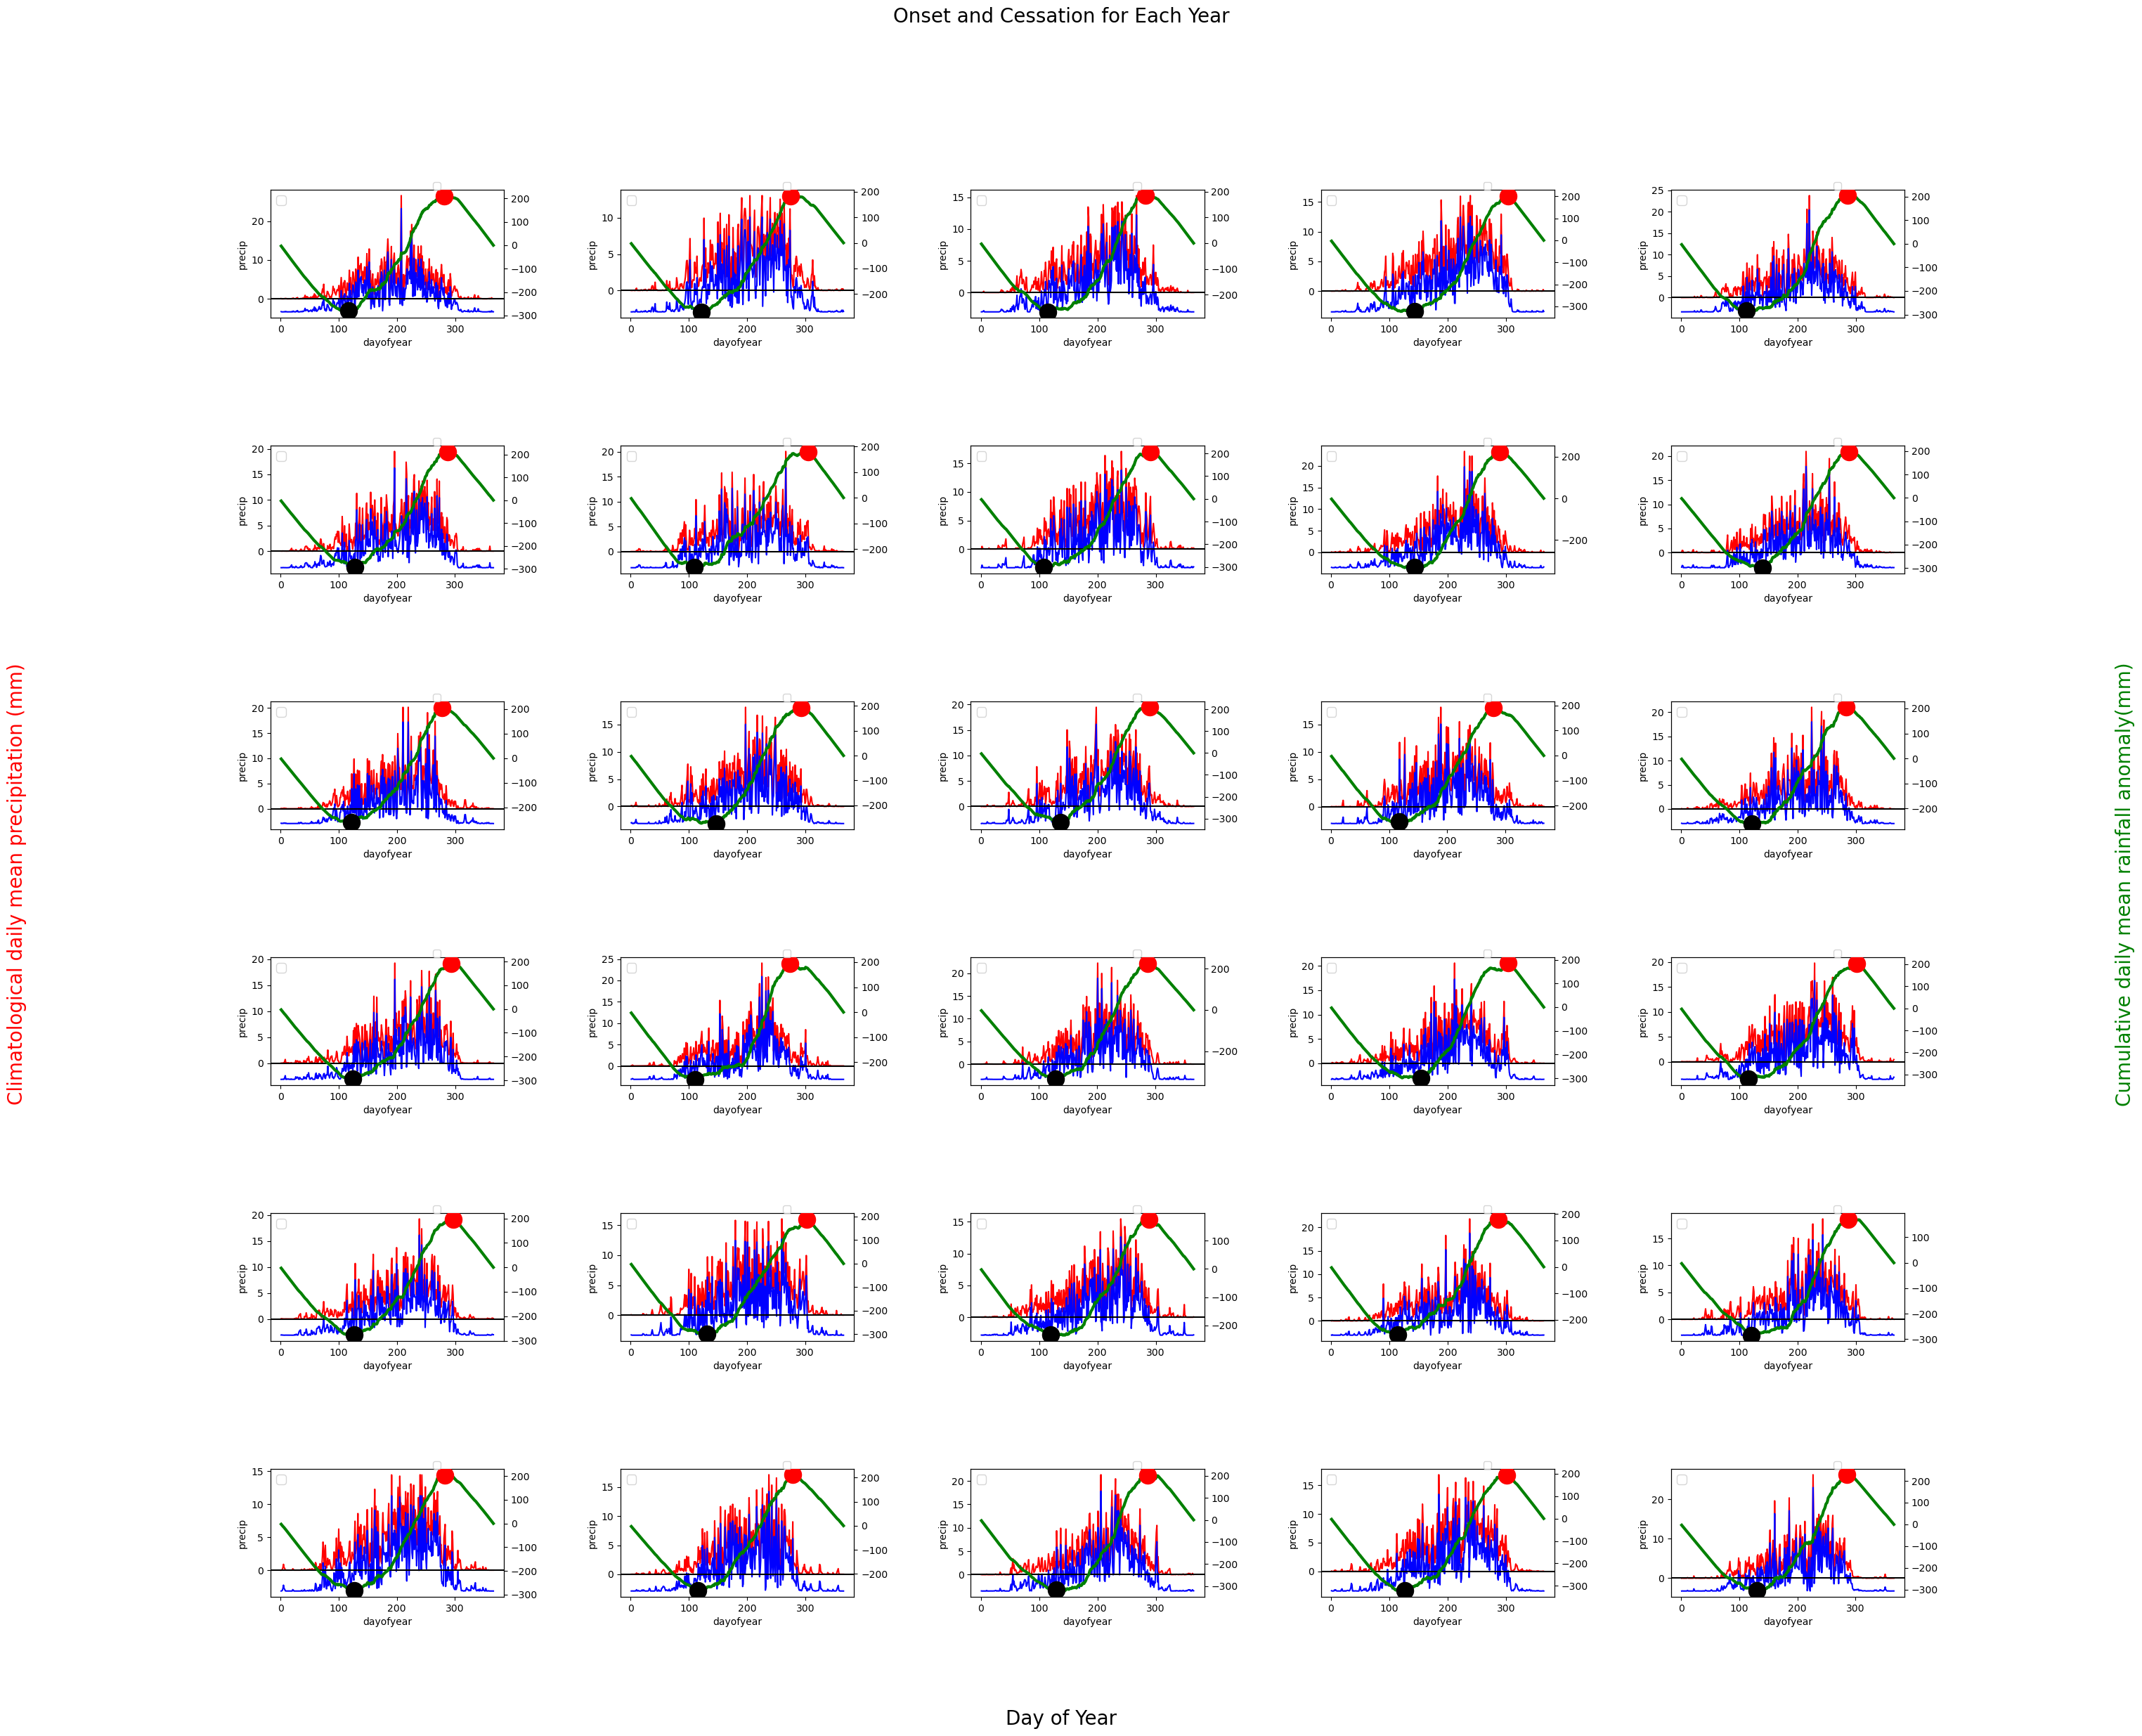

In [14]:
count = 0
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(30,26))#, sharex = True, sharey=True)
fig.suptitle('Onset and Cessation for Each Year', fontsize=20)
fig.text(0, 0.5, 'Climatological daily mean precipitation (mm)', va='center', rotation='vertical',fontsize=20, color='r')
fig.text(1, 0.5, 'Cumulative daily mean rainfall anomaly(mm)', va='center', rotation='vertical', fontsize=20, color='g')
fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=20)
plt.subplots_adjust(wspace=0.5, hspace=1)


for y, ax in zip(yearly_data,axes.flatten()):
#     ax = axes[count // 5, count % 5]  # Access the appropriate subplot based on count

    year = y[0]  #Extract the year from the data
    y1 = y[1].groupby('time.dayofyear').sum('time')
    x = y1.dayofyear
    #x = list(doy_data91.groups.copy())

    avg_data = inf_check(y1, grid=True)
    avg_data.plot(ax=ax, color='r')#, label='RR')
    ano(avg_data, dim="dayofyear").plot(ax=ax, color='b')#, label='anomaly')

    # Legend
    ax.legend(loc='upper left', fontsize=12)
#     ax.set_ylabel('Climatological daily mean precipitation(mm)', color='r', fontsize=12)
#     ax.set_xlabel('Day of Year', fontsize=14)
    ax.axhline(y=0, color='k')  # Horizontal black line at the zero mark

    ax1 = ax.twinx()
    anom = ano(avg_data, dim='dayofyear').cumsum()
    ax1.plot(x, anom, color='g', linewidth=3)
#     ax1.set_ylabel('Cumulative daily mean rainfall anomaly(mm)', fontsize=12, color='g')  # Set label

    # Onset and Cessation Detection
    anomaly = anom.values
    dx = 28  # Detection window (we use a nearly monthly interval to avoid multiple mid-month false onset)
    onset = []
    cessation = []
    for i in range(dx, len(anomaly) - dx):
        if np.min(anomaly[i - dx:i + dx]) == anomaly[i]:
            onset.append([i + 1, anomaly[i + 1]])
        if np.max(anomaly[i - dx:i + dx]) == anomaly[i]:
            cessation.append([i + 1, anomaly[i + 1]])

    ax1.scatter(np.copy(onset).T[0], np.copy(onset).T[1], 300, color='k', zorder=5)
    ax1.scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5) #label='cessation')
    ax1.legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))
    
    count += 1
# filterwarnings('ignore')    

plt.show
fig.savefig('Sudano-sahel_zone_yearly')


In [11]:
# for y, ax in zip(yearly_data,axes.flatten()):
#     print(y)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

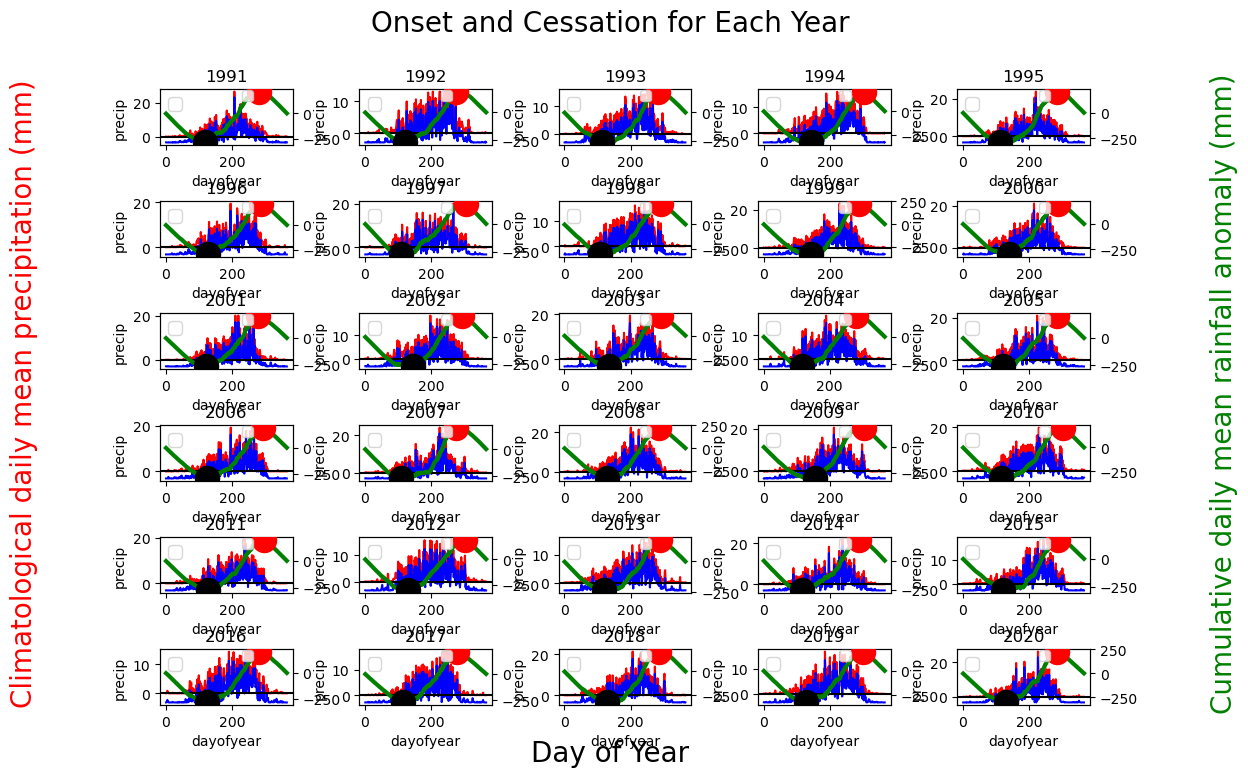

In [12]:
count = 0
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 8))
fig.suptitle('Onset and Cessation for Each Year', fontsize=20)
fig.text(0, 0.5, 'Climatological daily mean precipitation (mm)', va='center', rotation='vertical', fontsize=20, color='r')
fig.text(1, 0.5, 'Cumulative daily mean rainfall anomaly (mm)', va='center', rotation='vertical', fontsize=20, color='g')
fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=20)
plt.subplots_adjust(wspace=0.5, hspace=1)

for y, ax in zip(yearly_data, axes.flatten()):
    year = y[0]  # Extract the year from the data
    y1 = y[1].groupby('time.dayofyear').sum('time')
    x = y1.dayofyear

    avg_data = inf_check(y1, grid=True)
    avg_data.plot(ax=ax, color='r')
    ano(avg_data, dim="dayofyear").plot(ax=ax, color='b')

    ax.legend(loc='upper left', fontsize=12)
    ax.axhline(y=0, color='k')

    ax1 = ax.twinx()
    anom = ano(avg_data, dim='dayofyear').cumsum()
    ax1.plot(x, anom, color='g', linewidth=3)

    anomaly = anom.values
    dx = 28
    onset = []
    cessation = []
    for i in range(dx, len(anomaly) - dx):
        if np.min(anomaly[i - dx:i + dx]) == anomaly[i]:
            onset.append([i + 1, anomaly[i + 1]])
        if np.max(anomaly[i - dx:i + dx]) == anomaly[i]:
            cessation.append([i + 1, anomaly[i + 1]])

    ax1.scatter(np.copy(onset).T[0], np.copy(onset).T[1], 300, color='k', zorder=5)
    ax1.scatter(np.copy(cessation).T[0], np.copy(cessation).T[1], 300, color='r', zorder=5)
    ax1.legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))

    ax.set_title(str(year))  # Set the subplot title as the year

    count += 1

plt.show()